# *Chilling effect* - replication report

The aim of this notebook is to reproduce the figure 3 of the paper *CHILLING EFFECTS:
ONLINE SURVEILLANCE AND WIKIPEDIA USE* written in 2016 by Jonathon W. Penney.

### Context

In 2013, Snowden revealed to the world that Intelligence services were spying on their private searches and communications. Some organisms like Wikipedia and Wikimedia Foundation attacked these institutions because they feared a chilling effect, but they were considered too speculative.

Indeed, the article says that the skepticism around chilling effects is mainly due to the difficulty to establish either its presence or its absence and to mesure the extent of such an effect, as it lacks empirical study to prove it. It proposes therefore a first empirical study on this subject.

**Problem statement** : Did Wikipedia traffic for articles on privacy-sensitive topics decrease after the “exogenous shock” of widespread publicity surrounding the surveillance programs in June 2013?

**Hypothesis** : due to chilling effects caused by increased awareness of government surveillance online, Internet users will be less likely to view Wikipedia articles on topics that raise privacy-related concerns.

### Data

In the **first part of the replication**, we concentrate our analysis on a single dataset containing articles related to "terrorism".

`data/terrorism_data.csv`: A Wikipedia dataset containing specific articles (48) from the English Wikipedia that correspond with the DHS keywords listed as relating to “terrorism". It contains raw data from January 2012 to August 2014 to avoid the limitations of previous research on this topic (here the focus is on long term impact rather than being on direct impact from the even of 2013).

In the **second part of the replication**, we use a subset of the articles related to "terrorism" to keep only those that are most likely to raise privacy concerns for users (according to a MTurk privacy evaluation). 
We also use a dataset containing domestic security-related articles as a comparator/quasi-control group. We can consider the latter as a quasi-control group as :
- both set of articles have relatively close content that are likely to attract similar readers
- it should not raise privacy concerns for Wikipedia users concerned about government surveillance

`data/terrorism_data_30.csv`: A subset of the `data/terrorism_data.csv` dataset, containing 30 articles that are most likely to raise privacy concerns for users. Articles considered as outliers have already been removed from this dataset.

`data/domestic_data.csv`: A Wikipedia dataset containing domestic security-related articles (25) from the English Wikipedia.

### Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sn

## 1. Data Loading

In [2]:
# Data directory
data_dir = 'data/'

# Load datasets
terrorism_df = pd.read_csv(data_dir + 'terrorism_data.csv')
terrorism30_df = pd.read_csv(data_dir + 'terrorism_data_30.csv')
domestic_df = pd.read_csv(data_dir + 'domestic_data.csv')

## 2. Data Processing

##### terrorism dataframe

In [3]:
# Remove the undesired columns
terrorism_df = terrorism_df[['article', 'date', 'views']]

# Transform the date from str to pandas 
terrorism_df['date'] = pd.DatetimeIndex(terrorism_df['date'])

In [4]:
terrorism_df.head(5)

,article,date,views
0,abu_sayyaf,2012-01-01,254
1,afghanistan,2012-01-01,5241
2,agro,2012-01-01,27
3,al-qaeda,2012-01-01,2688
4,al-qaeda_in_the_arabian_peninsula,2012-01-01,104


##### terrorism_30 dataframe

In [5]:
# Remove the undesired columns
terrorism30_df = terrorism30_df[['article', 'date', 'views']]

# Transform the date from str to pandas 
terrorism30_df['date'] = pd.DatetimeIndex(terrorism30_df['date'])

In [6]:
terrorism30_df.head(5)

,article,date,views
0,abu_sayyaf,2012-01-01,254
1,al-qaeda,2012-01-01,2688
2,al-qaeda_in_the_arabian_peninsula,2012-01-01,104
3,al-qaeda_in_the_islamic_maghreb,2012-01-01,8
4,al-shabaab,2012-01-01,951


##### domestic dataframe

In [7]:
# Remove the undesired columns
domestic_df = domestic_df[['article', 'date', 'views']]

# Transform the date from str to pandas 
domestic_df['date'] = pd.DatetimeIndex(domestic_df['date'])

In [8]:
domestic_df.head(5)

,article,date,views
0,air_marshal,2012-01-01,383
1,alcohol_and_tobacco_tax_and_trade_bureau,2012-01-01,64
2,border_patrol,2012-01-01,38
3,bureau_of_land_management,2012-01-01,135
4,central_intelligence_agency,2012-01-01,2964


## 3. Replication (Figure 3)

### 3.1 First exploration of the data

As a first step, we reproduce the Figure 2 of the paper by computing the time series aggregated from the whole dataset and performing the two regressions (before and after June 2013).

In [10]:
# Define a constant for the date of revelation
revelation_date = pd.Timestamp('2013-06-15')

In [11]:
# Organise the data in a time series with the number of total views per day
terrorism_ts = terrorism_df.groupby(pd.Grouper(key="date", freq="1M")).sum()
terrorism_ts = terrorism_ts.reset_index().rename(columns={'index': 'date'})

# Separate the data in two to perform an ITS analysis
terrorism_pre_june_ts = terrorism_ts[terrorism_ts['date'] < revelation_date]
terrorism_post_june_ts = terrorism_ts[terrorism_ts['date'] > revelation_date]

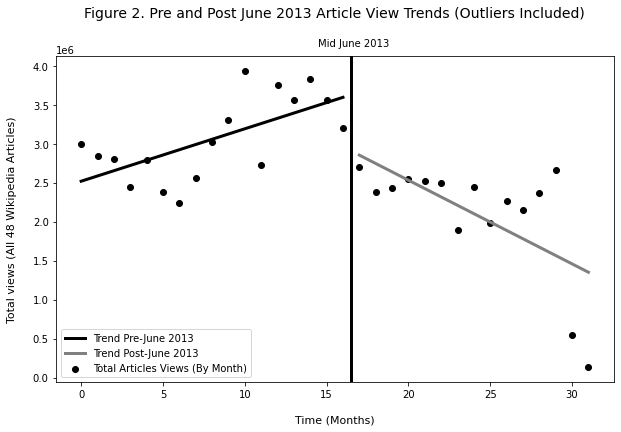

In [12]:
# Visualisation of full time series
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title('Figure 2. Pre and Post June 2013 Article View Trends (Outliers Included)\n\n', fontsize=14)
ax.set_xlabel('\nTime (Months)', fontsize=11)
ax.set_ylabel('Total views (All 48 Wikipedia Articles)\n', fontsize=11)

ax.scatter(terrorism_ts.index, terrorism_ts['views'], label='Total Articles Views (By Month)', color='black')

# Draw the regressions
slope_pre_june, intercept_pre_june, _, _, _ = stats.linregress(terrorism_pre_june_ts.index, 
                                                               terrorism_pre_june_ts['views'])
slope_post_june, intercept_post_june, _, _, _ = stats.linregress(terrorism_post_june_ts.index,
                                                                 terrorism_post_june_ts['views'])
x1 = terrorism_pre_june_ts.index
ax.plot(x1, intercept_pre_june + slope_pre_june*x1, color='black', linewidth='3', label='Trend Pre-June 2013')
x2 = terrorism_post_june_ts.index
ax.plot(x2, intercept_post_june + slope_post_june*x2, color='gray', linewidth='3', label='Trend Post-June 2013')

# Emphasise when the revelations occured 
revelation_date_integer = 16.5
ax.axvline(x=revelation_date_integer, ymin=0, ymax=4000000, color='black', linewidth='3')

x_text_offset = 14.5
y_text_offset = 4250000
ax.text(x_text_offset, y_text_offset, 'Mid June 2013', fontsize=10)

ax.legend(loc='lower left')
plt.show()

**Discussion** 

We observed that the data are not exactly similar with what the paper had at this stage:
1. The two "peak" outliers observed in the paper are not so pronounced (November 2012) or inexisting (July 2014) in our data
2. The total views are globally higher in the early 2013 than what is reported in Figure 2 of the paper
3. Our values in July and August 2014 are surpringly low in our plot (we will come back to it in 3.4)

### 3.2 Observation of outlier

By following their analysis, we should still have outlier(s) caused by wars that should be reflected in the *Hamas* article in November 2012 and August 2014.

In [13]:
hamas_df = terrorism_df[terrorism_df['article']=='hamas']
hamas_ts = hamas_df.groupby(pd.Grouper(key="date", freq="1MS")).sum()

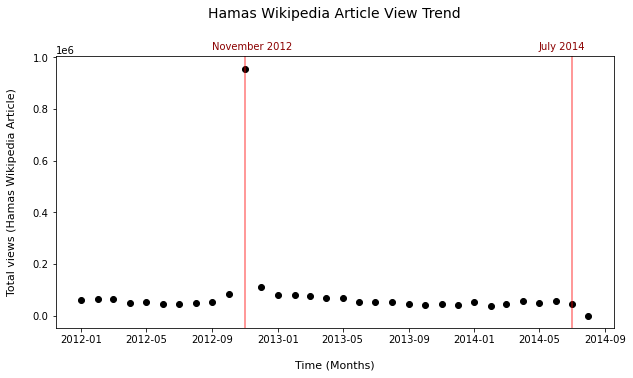

In [14]:
# Visualisation of hamas time series
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_title('Hamas Wikipedia Article View Trend\n\n', fontsize=14)
ax.set_xlabel('\nTime (Months)', fontsize=11)
ax.set_ylabel('Total views (Hamas Wikipedia Article)\n', fontsize=11)

ax.scatter(hamas_ts.index, hamas_ts['views'], color='black')

# Emphasise the wars where the Hamas got involved
first_war_date = pd.Timestamp('2012-11-01')
ax.axvline(x=first_war_date, ymin=0, ymax=1000000, color='red', alpha=0.4, linewidth='2')

x1_text_offset = pd.Timestamp('2012-09-01')
y1_text_offset = 1030000
ax.text(x1_text_offset, y1_text_offset, 'November 2012', color='darkred', fontsize=10)

second_war_date = pd.Timestamp('2014-07-01')
ax.axvline(x=second_war_date, ymin=0, ymax=1000000, color='red', alpha=0.4, linewidth='2')
x2_text_offset = pd.Timestamp('2014-05-01')
y2_text_offset = 1030000
ax.text(x2_text_offset, y2_text_offset, 'July 2014', color='darkred', fontsize=10)

plt.show()

**Discussion:** 

We indeed observe a strong outlier in November 2012. As this sudden interest in the Hamas article is caused by a specific event (a war) that has been put in the spotlight by media worldwide, it seems wiser to remove the Hamas article  from our analysis as it can badly impact our regression analysis.  

*Note*: The second outlier observed in June 2014 mentionned in the paper doesn't appear in our data (we will discuss it in 3.4)

### 3.3 Result of the replication

We finally replicate the last step from the analysis of the author and display the desired result - Figure 3.

In [15]:
# Organise the data in a time series with the number of total views per day without the Hamas article
terrorism_cleaned_df = terrorism_df[~(terrorism_df['article']=='hamas')]
terrorism_cleaned_ts = terrorism_cleaned_df.groupby(pd.Grouper(key="date", freq="1M")).sum()
terrorism_cleaned_ts = terrorism_cleaned_ts.reset_index().rename(columns={'index': 'date'})

# Separate the data in two to perform a second ITS analysis
terrorism_cleaned_pre_june_ts = terrorism_ts[terrorism_cleaned_ts['date'] < revelation_date]
terrorism_cleaned_post_june_ts = terrorism_ts[terrorism_cleaned_ts['date'] > revelation_date]

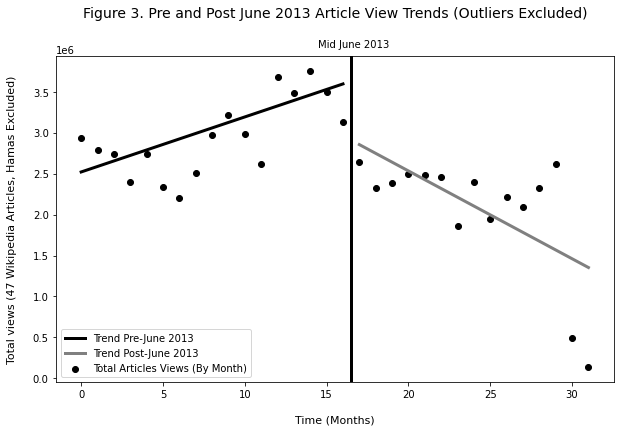

In [16]:
### Show the final figure and compute regression line
# Visualisation of full time series without the Hamas article
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title('Figure 3. Pre and Post June 2013 Article View Trends (Outliers Excluded)\n\n', fontsize=14)
ax.set_xlabel('\nTime (Months)', fontsize=11)
ax.set_ylabel('Total views (47 Wikipedia Articles, Hamas Excluded)\n', fontsize=11)

ax.scatter(terrorism_cleaned_ts.index, terrorism_cleaned_ts['views'], 
           label='Total Articles Views (By Month)', color='black')

# Draw the regressions
slope_pre_june, intercept_pre_june, _, _, _ = stats.linregress(terrorism_cleaned_pre_june_ts.index, 
                                                               terrorism_cleaned_pre_june_ts['views'])
slope_post_june, intercept_post_june, _, _, _ = stats.linregress(terrorism_cleaned_post_june_ts.index,
                                                                 terrorism_cleaned_post_june_ts['views'])
x1 = terrorism_cleaned_pre_june_ts.index
ax.plot(x1, intercept_pre_june + slope_pre_june*x1, color='black', linewidth='3', label='Trend Pre-June 2013')
x2 = terrorism_cleaned_post_june_ts.index
ax.plot(x2, intercept_post_june + slope_post_june*x2, color='gray', linewidth='3', label='Trend Post-June 2013')

# Emphasise when the revelations occured 
revelation_date_integer = 16.5
ax.axvline(x=revelation_date_integer, ymin=0, ymax=4000000, color='black', linewidth='3')

x_text_offset = 14.5
y_text_offset = 4050000
ax.text(x_text_offset, y_text_offset, 'Mid June 2013', fontsize=10)

ax.legend(loc='lower left')
plt.show()

**Discussion** 

As with Figure 2, we observe here that our data are not exactly similar with those in the paper. The main difference which follows from this is that in our regression analysis, the second regression is steeper than the one in the paper. Although, from our analysis we arrive at the same conclusion as in the paper:

1. There is a significant reduction in article views just after the revelations of June 2013, which goes along the hypothesis of a sudden chilling effect.
2. The trend reversal observed before and after June 2013 goes along the hypothesis of a **long term** chilling effect.

*Note:* Still we observe that the replication is not perfect as the data we have in July 2014 and August 2014 seems to be outliers.

### 3.4 Beyond replication

We see from the analysis performed that we didn't use the exact same data as in the paper. Indeed, the peak outlier that we were supposed to observe in July 2014 in part 3.2 happened to have very few view counts.

Looking at the data in https://www.wikishark.com/title/en/Hamas, we see that July 2014 should be an outlier in term of view counts for the Hamas article in Wikipedia (english) and the problem come thus from our dataset.

Therefore, if we would like to go beyond the *strict* replication of the paper, we could remove these two outliers (July and August 2014) from our dataset to observe a better regression analysis, closer to the one of Figure 3 in the paper.

## 4. Replication (Figure 4a)

In the previous section, we observed what looks like a long term chilling effect using the terrorism dataframe. However, we need to compare this result with a control group to verify that the chilling effect only happens on privacy-sensitive articles, otherwise the analysis would not be valid (another factor would explain this situation).

To have a good control group, we need to have a dataframe with the two following property :

- it should contain articles that target the same public as the terrorism articles dataframe
- the articles of the control group should not be privacy-sensitive and hence, should not be affected by chilling effects.

Such a control group is complicated to define as the behaviour of online users is complex and hard to generalise.
Hence, we will use the domestic security dataframe as a quasi-control group : it is a topic related to terrorism, but which is less concerned with privacy issues.

**Note**: we will use terrorism30_df dataframe, as it contains the articles that are most privacy-sensitive according to a MTurk privacy evaluation mentionned in the paper we are reproducing.

### 4.1 Perform a first comparative analysis

In [17]:
# Organise the data in a time series with the number of total views per month
terrorism30_ts = terrorism30_df.groupby(pd.Grouper(key="date", freq="1M")).sum()
terrorism30_ts = terrorism30_ts.reset_index().rename(columns={'index': 'date'})

domestic_ts = domestic_df.groupby(pd.Grouper(key="date", freq="1M")).sum()
domestic_ts = domestic_ts.reset_index().rename(columns={'index': 'date'})

# Separate the data in two to perform an ITS analysis
terrorism30_pre_june_ts = terrorism30_ts[terrorism30_ts['date'] < revelation_date]
terrorism30_post_june_ts = terrorism30_ts[terrorism30_ts['date'] > revelation_date]

domestic_pre_june_ts = domestic_ts[domestic_ts['date'] < revelation_date]
domestic_post_june_ts = domestic_ts[domestic_ts['date'] > revelation_date]

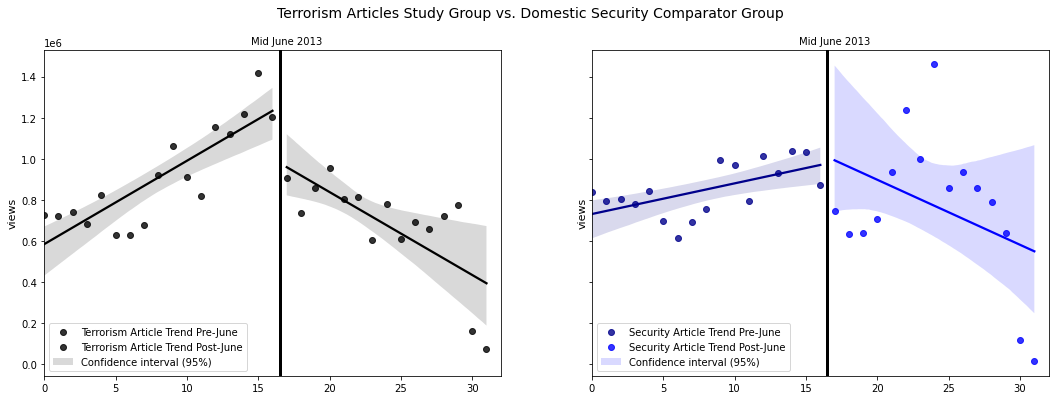

In [18]:
### Show the final figure with both terrorism articles study group and the comparator group

fig, ax = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

fig.suptitle('Terrorism Articles Study Group vs. Domestic Security Comparator Group\n\n', fontsize=14)

## Visualisation of the full terrorism30 time series
ax[0].set_xlabel('\nTime (Months)', fontsize=11)
ax[0].set_xlim(0, 32)
ax[0].set_ylabel('Total views (All Articles)\n', fontsize=11)

# Draw the data points, regressions & CIs on terrorism data (pre/post june)
x1 = terrorism30_pre_june_ts.index
y1 = terrorism30_pre_june_ts['views']
sn.regplot(x1, y1, data=terrorism30_pre_june_ts, color="black",
           label="Terrorism Article Trend Pre-June", scatter=True, n_boot=10000, ax=ax[0])

x2 = terrorism30_post_june_ts.index
y2 = terrorism30_post_june_ts['views']
sn.regplot(x2, y2, data=terrorism30_post_june_ts, color="black",
           label="Terrorism Article Trend Post-June", scatter=True, n_boot=10000, ax=ax[0])

## Visualisation of the full domestic security time series
ax[1].set_xlabel('\nTime (Months)', fontsize=11)
ax[1].set_xlim(0, 32)
ax[1].set_ylabel('Total views (All Articles)\n', fontsize=11)

# Draw the data points, regressions & CIs on domestic security data (pre/post june)
x1 = domestic_pre_june_ts.index
y1 = domestic_pre_june_ts['views']
sn.regplot(x1, y1, data=domestic_pre_june_ts, color="darkblue",
           label="Security Article Trend Pre-June", scatter=True, n_boot=10000, ax=ax[1])

x2 = domestic_post_june_ts.index
y2 = domestic_post_june_ts['views']
sn.regplot(x2, y2, data=domestic_post_june_ts, color="blue",
           label="Security Article Trend Post-June", scatter=True, n_boot=10000, ax=ax[1])

## Emphasise when the revelations occured 
revelation_date_integer = 16.5
ax[0].axvline(x=revelation_date_integer, ymin=0, ymax=4000000, color='black', linewidth='3')
ax[1].axvline(x=revelation_date_integer, ymin=0, ymax=4000000, color='black', linewidth='3')

x_text_offset = 14.5
y_text_offset = 1560000
ax[0].text(x_text_offset, y_text_offset, 'Mid June 2013', fontsize=10)
ax[1].text(x_text_offset, y_text_offset, 'Mid June 2013', fontsize=10)

ax[0].collections[3].set_label('Confidence interval (95%)')
ax[1].collections[3].set_label('Confidence interval (95%)')

ax[0].legend(loc='lower left')
ax[1].legend(loc='lower left')

plt.show()

These results are interesting, but we observe some outliers that may interfer with the analysis :

- As mention in section 3.4, the points corresponding to the two last year of our analysis are clearly outliers and does not appear in the paper of Dr. Penney nor on Google Trend. We will therefore remove them.
- The domestic security dataframe seems to contain outliers, as we observe two points abnormally high near the 25th month of the time serie.

### 4.2 Look for outliers in the domestic security dataframe

Inspecting in the list of articles from the domestic security dataframe, we plotted the time series of several articles (taken individually) and we observe that some of them behave irregularly.

In [19]:
set(domestic_df['article'])

{'air_marshal',
 'alcohol_and_tobacco_tax_and_trade_bureau',
 'border_patrol',
 'bureau_of_land_management',
 'central_intelligence_agency',
 'coast_guard',
 'customs_and_border_protection',
 'dea',
 'emergency_management',
 'espionage',
 'federal_air_marshal_service',
 'federal_aviation_administration',
 'federal_bureau_of_investigation',
 'federal_emergency_management_agency',
 'fusion_center',
 'homeland_defense',
 'national_guard',
 'secret_service',
 'secure_border_initiative',
 'task_force_88_(anti-terrorist_unit)',
 'transportation_security_administration',
 'u.s._immigration_and_customs_enforcement',
 'united_nations',
 'united_states_citizenship_and_immigration_services',
 'united_states_department_of_homeland_security'}

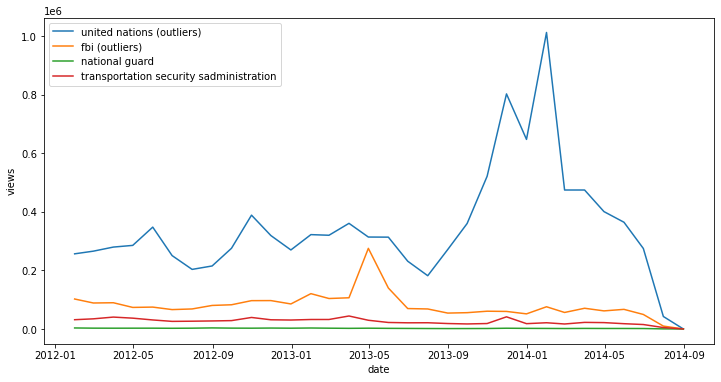

In [20]:
# Create time series for individual articles following their number of total views per month
un_df = domestic_df[(domestic_df['article']=='united_nations')]
un_ts = un_df.groupby(pd.Grouper(key="date", freq="1M")).sum()
un_ts = un_ts.reset_index().rename(columns={'index': 'date'})

fbi_df = domestic_df[(domestic_df['article']=='federal_bureau_of_investigation')]
fbi_ts = fbi_df.groupby(pd.Grouper(key="date", freq="1M")).sum()
fbi_ts = fbi_ts.reset_index().rename(columns={'index': 'date'})

ng_df = domestic_df[(domestic_df['article']=='national_guard')]
ng_ts = ng_df.groupby(pd.Grouper(key="date", freq="1M")).sum()
ng_ts = ng_ts.reset_index().rename(columns={'index': 'date'})

tsa_df = domestic_df[(domestic_df['article']=='transportation_security_administration')]
tsa_ts = tsa_df.groupby(pd.Grouper(key="date", freq="1M")).sum()
tsa_ts = tsa_ts.reset_index().rename(columns={'index': 'date'})

# Visualise the time seres
fig, ax = plt.subplots(figsize=(12, 6))

sn.lineplot(data=un_ts, x='date', y='views', label='united nations (outliers)', ax=ax)
sn.lineplot(data=fbi_ts, x='date', y='views', label='fbi (outliers)', ax=ax)
sn.lineplot(data=ng_ts, x='date', y='views', label='national guard',ax=ax)
sn.lineplot(data=tsa_ts, x='date', y='views', label='transportation security sadministration',ax=ax)

ax.legend(loc='upper left')

Among the articles in the domestic security dataframe, we observe that the United Nations article is a strong outlier, so is the FBI article (on a smaller scale). 

We have now all the informations we need to remove the outliers we have observed previously.

**Remove outliers**

In [21]:
# Remove outliers from domestic dataframe : United Nations & Federal Bureau of Investigation
domestic_cleaned_df = domestic_df[~(domestic_df['article']=='united_nations')]
domestic_cleaned_df = domestic_cleaned_df[~(domestic_cleaned_df['article']=='federal_bureau_of_investigation')]

In [22]:
# Organise the data in a new time series with the number of total views per month
domestic_cleaned_ts = domestic_cleaned_df.groupby(pd.Grouper(key="date", freq="1M")).sum()
domestic_cleaned_ts = domestic_cleaned_ts.reset_index().rename(columns={'index': 'date'})

# Remove the two last months (as discussed in 3.4)
terrorism30_cleaned_ts = terrorism30_ts[:-2]
domestic_cleaned_ts = domestic_cleaned_ts[:-2]

### 4.3 Final comparative analysis (result of the replication)

With all the dataframe cleaned, let's perform the comparative analysis again.

In [23]:
# Separate the data in two to perform an ITS analysis
terrorism30_cleaned_pre_june_ts = terrorism30_cleaned_ts[terrorism30_cleaned_ts['date'] < revelation_date]
terrorism30_cleaned_post_june_ts = terrorism30_cleaned_ts[terrorism30_cleaned_ts['date'] > revelation_date]

domestic_cleaned_pre_june_ts = domestic_cleaned_ts[domestic_cleaned_ts['date'] < revelation_date]
domestic_cleaned_post_june_ts = domestic_cleaned_ts[domestic_cleaned_ts['date'] > revelation_date]

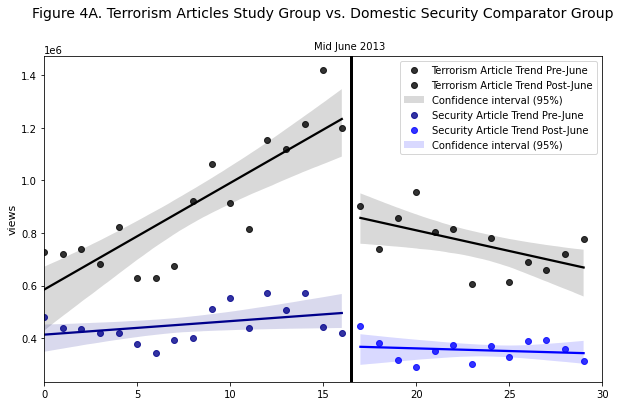

In [24]:
### Show the final figure with both terrorism articles study group and the comparator group
## Visualisation of the full time series
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title('Figure 4A. Terrorism Articles Study Group vs. Domestic Security Comparator Group\n\n', fontsize=14)
ax.set_xlabel('\nTime (Months)', fontsize=11)
ax.set_xlim(0, 30)
ax.set_ylabel('Total views (All Articles)\n', fontsize=11)


## Draw the data points, regressions & CIs
# on terrorism data (pre/post june)
x1 = terrorism30_cleaned_pre_june_ts.index
y1 = terrorism30_cleaned_pre_june_ts['views']
sn.regplot(x1, y1, data=terrorism30_cleaned_pre_june_ts, color="black",
           label="Terrorism Article Trend Pre-June", scatter=True, n_boot=10000, ax=ax)

x2 = terrorism30_cleaned_post_june_ts.index
y2 = terrorism30_cleaned_post_june_ts['views']
sn.regplot(x2, y2, data=terrorism30_cleaned_post_june_ts, color="black",
label="Terrorism Article Trend Post-June", scatter=True, n_boot=10000)

# on domestic security data (pre/post june)
x1 = domestic_cleaned_pre_june_ts.index
y1 = domestic_cleaned_pre_june_ts['views']
sn.regplot(x1, y1, data=domestic_cleaned_pre_june_ts, color="darkblue",
           label="Security Article Trend Pre-June", scatter=True, n_boot=10000, ax=ax)

x2 = domestic_cleaned_post_june_ts.index
y2 = domestic_cleaned_post_june_ts['views']
sn.regplot(x2, y2, data=domestic_cleaned_post_june_ts, color="blue",
           label="Security Article Trend Post-June", scatter=True, n_boot=10000, ax=ax)

## Emphasise when the revelations occured 
revelation_date_integer = 16.5
ax.axvline(x=revelation_date_integer, ymin=0, ymax=4000000, color='black', linewidth='3')

x_text_offset = 14.5
y_text_offset = 1500000
ax.text(x_text_offset, y_text_offset, 'Mid June 2013', fontsize=10)

ax.collections[3].set_label('Confidence interval (95%)')
ax.collections[7].set_label('Confidence interval (95%)')

ax.legend(loc='upper right')

plt.show()

**Discussion**: The results of the final analysis tend to confirm our hypothesis.

1. There is a significant reduction in article views just after the revelations of June 2013, which goes along the hypothesis of a sudden chilling effect for the most privacy-sensitive articles related to terrorism.
2. The trend reversal observed before and after June 2013 goes along the hypothesis of a **long term** chilling effect.
3. Except a rather small drop in articles views in June 2013, we do not observe any evidence of chilling effects on the quasi-control group as expected (to validate the hypothesis).

## 5. Conclusion

We achieve to replicate the main results from the paper *CHILLING EFFECTS: ONLINE SURVEILLANCE AND WIKIPEDIA USE*.

One main difference between the paper and the replication is that the datasets were extracted using different means. Indeed the paper to the website "http://stats.grok.se/" to retrieve the dataset, but this site is not available and we hence couldn't work with the exact same data. The latter redirect us to wikishark which display the same data as in the paper (at least for some selected articles like 'Hamas'), but does not furnish a .csv file of these data.